In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc

# Dataset

## Visualization utils

In [2]:
def plot_samples(dataset, split, seed):
    global class_to_id
    np.random.seed(seed)
    print(f"Plot Samples (seed = {seed}, {split} split)")
    
    llb = list(class_to_id.keys())
    

    plt.figure(figsize=(10, 5))
    found_samples = {i: False for i in range(8)}
    
    while not all(found_samples.values()):
        idx = np.random.randint(0, len(dataset))
        image , label = dataset[idx]
        if found_samples[label]:
            continue
        
        plt.subplot(2, 4, label + 1)
        plt.imshow(image.squeeze().permute(1, 2, 0))
        plt.title(f'{label}. {llb[label]}')
        plt.axis('off')
        found_samples[label] = True
    plt.tight_layout()
    plt.show()

In [3]:
def plot_label_distribution_histogram(dataset, split):
    if type(dataset) == torch.utils.data.dataset.ConcatDataset:
        labels = []
        for d in dataset.datasets:
            labels += d.targets
    elif type(dataset) == list:
        labels = [label for _, label in dataset]
    else:
        labels = dataset.targets
    labels, counts = np.unique(labels, return_counts=True)

    fig, ax = plt.subplots()
    ax.bar(range(8), counts)

    for i in range(8):
        ax.text(i, counts[i], f"{100*(counts[i]/sum(counts)):.1f} %", ha="center", va="bottom")

    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(8))
    ax.set_xticklabels(range(8), ha="center")
    ax.set_title(f"Histogram of labels distribution for {split} split")
    plt.tight_layout()
    plt.show()

## Load and Prepare datasets

In [4]:
TRAIN_DATA_PATH = "dataset/TRAIN"
TUNE_DATA_PATH = "dataset/TUNE"
TRAIN_SPLIT_OF_ALL = 0.8

In [5]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
transforms_augment = transforms.Compose([
    transforms.RandomRotation(degrees=20), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    scale,
])
transforms_norm = transforms.Compose([
    transforms.ToTensor(),
    scale,
])

train_valid_aug_dataset = ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=transforms_augment,
)
train_valid_raw_dataset = ImageFolder(
    root=TRAIN_DATA_PATH,
    transform=transforms_norm,
)
train_valid_dataset = torch.utils.data.ConcatDataset([train_valid_raw_dataset, train_valid_aug_dataset])
tune_dataset = ImageFolder(
    root=TUNE_DATA_PATH,
    transform=transforms_norm,
)

class_to_id = tune_dataset.class_to_idx

## Explore datasets

Plot Samples (seed = 21, train+valid split)


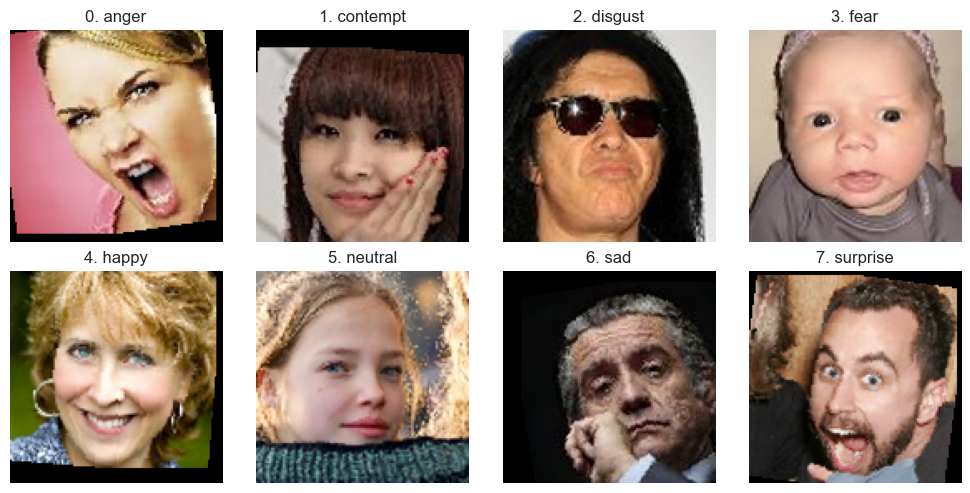

In [7]:
plot_samples(
    dataset=train_valid_dataset, 
    split="train+valid", 
    seed=21,
)

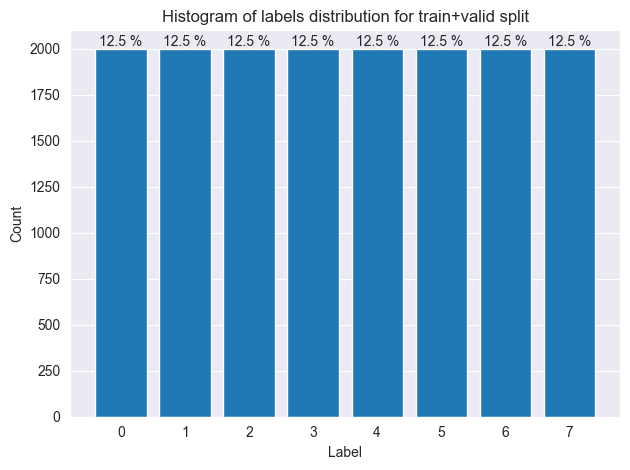

In [8]:
plot_label_distribution_histogram(
    dataset=train_valid_dataset, 
    split="train+valid",
)

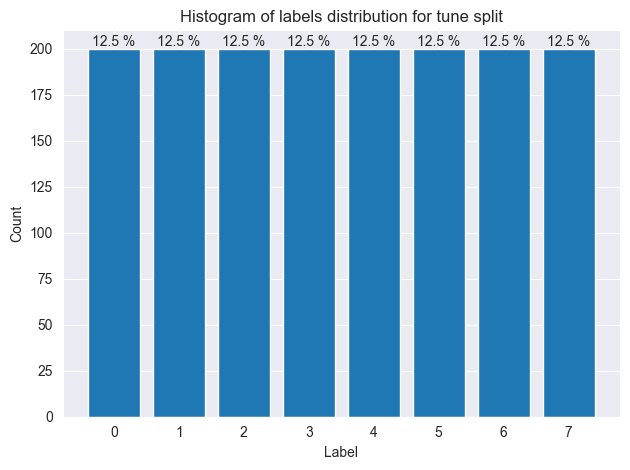

In [9]:
plot_label_distribution_histogram(
    dataset=tune_dataset, 
    split="tune",
)

## Split train-validation

In [10]:
labels = []
for d in train_valid_dataset.datasets:
    labels += d.targets

train_dataset, valid_dataset = train_test_split(
    train_valid_dataset,
    train_size=TRAIN_SPLIT_OF_ALL,
    stratify=labels,
    random_state=42
)

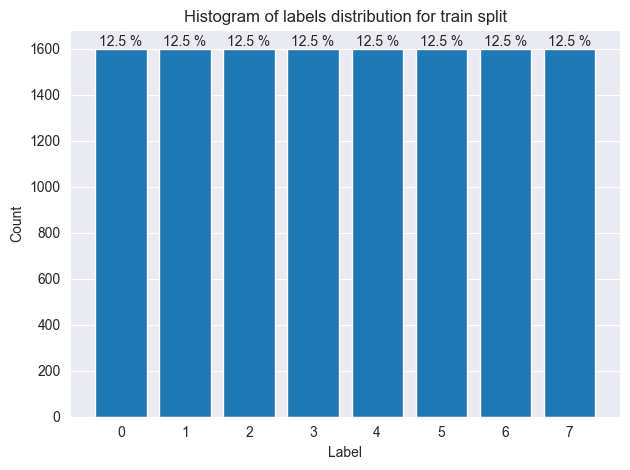

In [11]:
plot_label_distribution_histogram(
    dataset=train_dataset, 
    split="train",
)

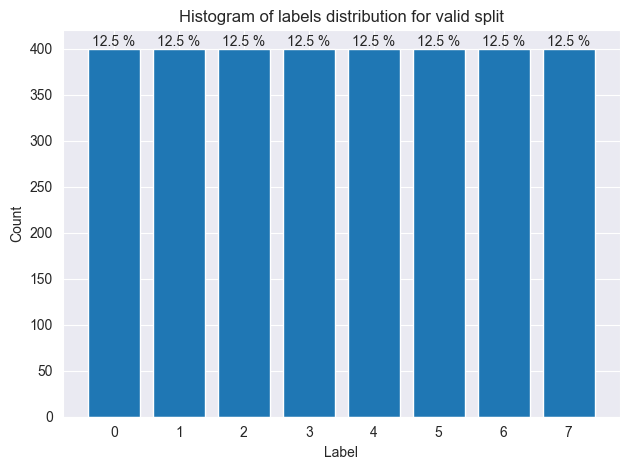

In [12]:
plot_label_distribution_histogram(
    dataset=valid_dataset, 
    split="valid",
)

# Models

## Utils

### Train-Eval helpers

In [13]:
@torch.no_grad()
def model_eval(model, loader, loss_function=nn.CrossEntropyLoss(), device="auto"):
    """Returns test_loss, test_accuracy"""
    test_loss = 0.0
    test_correct = 0
    sample_count = 0
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()
        sample_count += np.shape(inputs)[0]

        itr.set_description("(Eval)")
        itr.set_postfix(loss=round(loss.item(), 5), accuracy=round(test_correct/sample_count, 2))

    test_loss = test_loss / len(loader)
    test_acc = test_correct / sample_count

    return test_loss, test_acc


In [14]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        test_set=None,
        device="auto",
):
    """
    If test_set is not None, it would evaluate model for each epoch,
    train_set would be in  N*(img, label) format.
    """
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    needs_test_evaluation = test_set is not None

    train_loss_list = []
    train_acc_list = []

    test_loss_list = None if test_set is None else []
    test_acc_list = None if test_set is None else []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    if needs_test_evaluation:
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        samples_count = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for inputs, labels in itr:
            samples_count += np.shape(inputs)[0]
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()


            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(loss=round(loss.item(), 5), accuracy=round(train_correct/samples_count, 3))

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        if needs_test_evaluation:
            test_loss, test_acc = model_eval(
                model=model,
                device=device,
                loader=test_loader,
            )

            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)

    history = {
        "train loss": train_loss_list,
        "train acc": train_acc_list,
    }
    if needs_test_evaluation:
        history.update({
            "test loss": test_loss_list,
            "test acc": test_acc_list,
        })

    return history

## Visualization

In [29]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, data in plots:
            plt.plot(range(1, len(data)+1), data, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [26]:
@torch.no_grad()
def generate_roc_plot(model, dataset, device='auto'):
    global class_to_id
    llb = list(class_to_id.keys())
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    probabilities = []
    labels = []
    
    for data, label in tqdm(loader, leave=False, desc="Generate data"):
        data = data.to(device)
        label = label.to(device)
        
        prob = model(data)
        
        probabilities.append(prob.detach())
        labels.append(label)
        
    probabilities = torch.cat(probabilities, dim=0)
    labels = torch.cat(labels, dim=0)
    
    fpr = dict()
    tpr = dict()
    auc = {}
    for i in tqdm(range(8), leave=False, desc="Calculate ROC/AUC"):
        fpr[i], tpr[i], _ = metrics.roc_curve(labels == i, probabilities[:, i])
        auc[i] = metrics.auc(fpr[i], tpr[i])
        
    plt.figure()
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance Level (AUC = 0.5)")
    for i in tqdm(range(8), leave=False, desc="Generate plot"):
        plt.plot(fpr[i], tpr[i], label=f'[{i}] Class {llb[i]} (auc: {auc[i]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
        

In [50]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    global class_to_id
    llb = list(class_to_id.keys())
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    probabilities = []
    labels = []
    
    for data, label in tqdm(loader, leave=False, desc="Generate data"):
        data = data.to(device)
        label = label.to(device)
        
        prob = model(data)
        
        probabilities.append(prob.detach())
        labels.append(label)
    print(np.shape(probabilities), np.shape(labels))
    probabilities = torch.cat(probabilities, dim=0)
    _, predicted = torch.max(probabilities.detach(), dim=1)
    labels = torch.cat(labels, dim=0).detach().squeeze().numpy()
    predicted = predicted.detach().squeeze().numpy()
    print(np.shape(predicted), np.shape(labels))
    
    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
        # labels=llb,
    )
    
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",
                xticklabels=llb, yticklabels=llb)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)
    
    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}
    

### Costume conv block

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel=(3,3), stride=(1,1), padding="same"):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel, padding=padding, stride=stride),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.block(x)
        

## AlexNet model

In [19]:
class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        
        self.network = nn.Sequential(
            ConvBlock(in_chan=in_channel, out_chan=16, kernel=(9,9)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=16, out_chan=32, kernel=(7,7)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=32, out_chan=64, kernel=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=64, out_chan=128, kernel=(3, 3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=128, out_chan=128, kernel=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=1024, out_features=num_classes),
        )
        
        self.av_net = nn.Linear(num_classes, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        return self.softmax(self.network(x))
        

## VGG model

In [19]:
class VGG(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(VGG, self).__init__()
        
        self.network = nn.Sequential(
            ConvBlock(in_chan=in_channel, out_chan=16, kernel=(3,3)),
            ConvBlock(in_chan=16, out_chan=16, kernel=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=16, out_chan=32, kernel=(3,3)),
            ConvBlock(in_chan=32, out_chan=32, kernel=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=32, out_chan=64, kernel=(3,3)),
            ConvBlock(in_chan=64, out_chan=64, kernel=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=64, out_chan=128, kernel=(3, 3)),
            ConvBlock(in_chan=128, out_chan=128, kernel=(3, 3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            ConvBlock(in_chan=128, out_chan=128, kernel=(3,3)),
            ConvBlock(in_chan=128, out_chan=128, kernel=(3,3)),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=1024, out_features=num_classes),
        )
        
        self.av_net = nn.Linear(num_classes, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        return self.softmax(self.network(x))
        

## MobileNet model

# Train and Tune models

## AlexNet

In [20]:
alexnet_model = AlexNet(in_channel=3, num_classes=8)

# train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=400, shuffle=False)
# Tune_loader = DataLoader(tune_dataset, batch_size=400, shuffle=True)

In [21]:
alexnet_train_history = train_model(
    model=alexnet_model,
    batch_size=400,
    loss_function=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(alexnet_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8),
    epochs=24,
    train_set=train_dataset,
    test_set=valid_dataset,
)

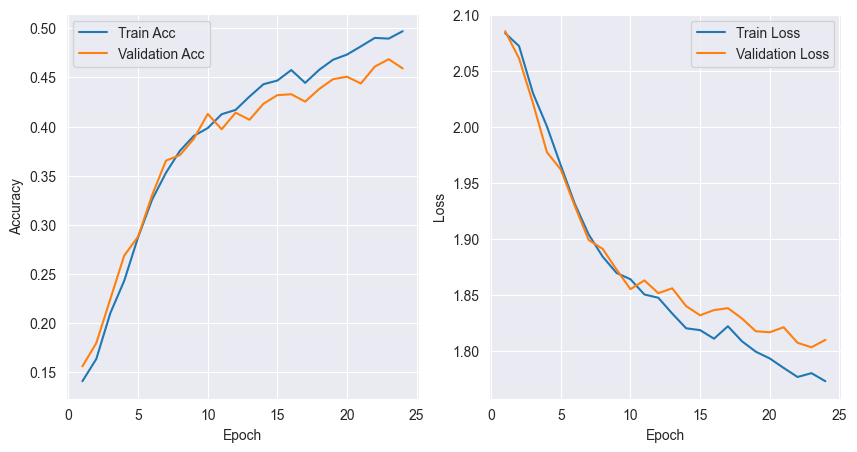

In [31]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", alexnet_train_history["train acc"]),
            ("Validation Acc", alexnet_train_history["test acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", alexnet_train_history["train loss"]),
            ("Validation Loss", alexnet_train_history["test loss"])
        ]
    }
)


In [23]:
alexnet_tune_history = train_model(
    model=alexnet_model,
    batch_size=32, # 400 in paper, but 32 seems to work better
    loss_function=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(alexnet_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2),
    epochs=16,
    train_set=tune_dataset,
    test_set=valid_dataset,
)

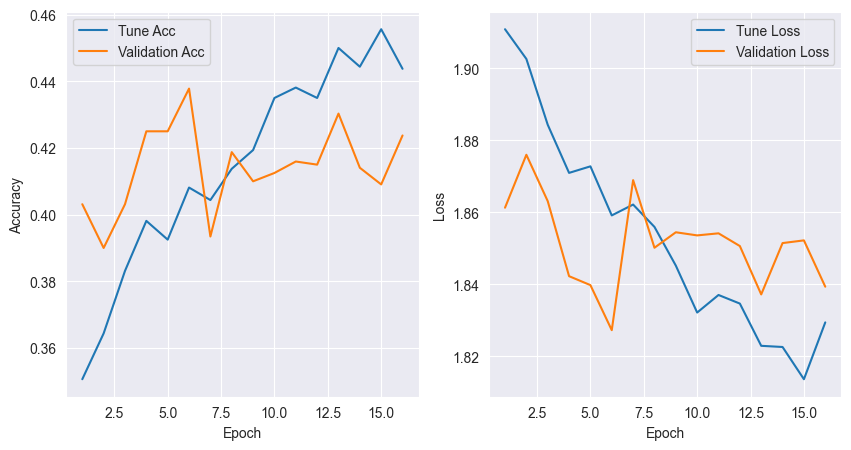

In [30]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Tune Acc", alexnet_tune_history["train acc"]),
            ("Validation Acc", alexnet_tune_history["test acc"]),
        ],
        "Loss - Epoch": [
            ("Tune Loss", alexnet_tune_history["train loss"]),
            ("Validation Loss", alexnet_tune_history["test loss"])
        ]
    }
)


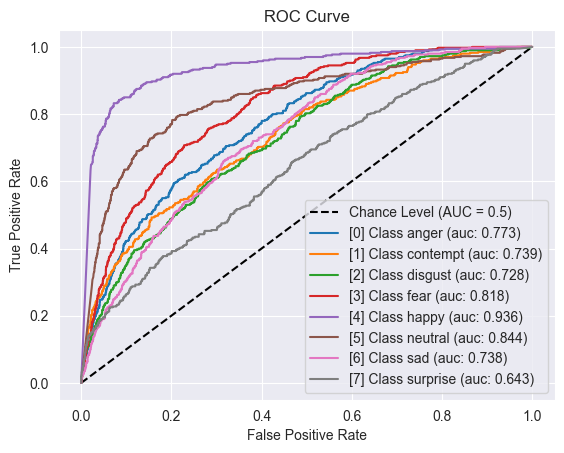

In [27]:
generate_roc_plot(
    model=alexnet_model,
    dataset=valid_dataset,
)

(100, 32, 8) (100, 32)
(3200,) (3200,)


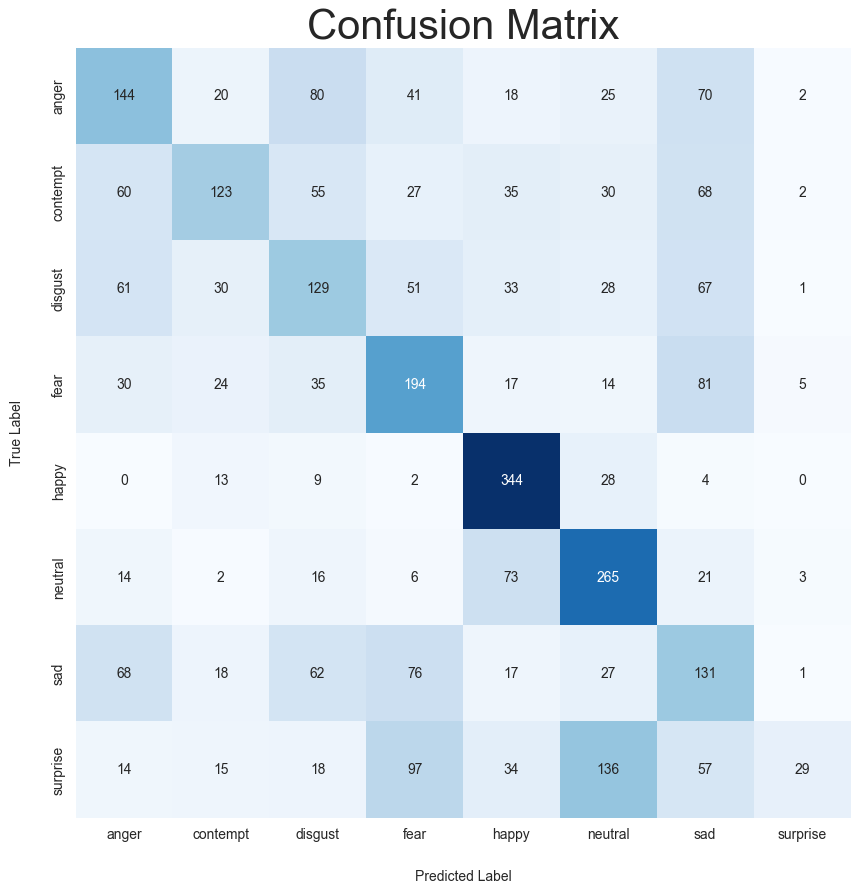

In [51]:
alexnet_report = generate_confusion_matrix(
    model=alexnet_model, 
    dataset=valid_dataset,
)

In [55]:
print(f"Recall:    {alexnet_report['recall']:.3f}")
print(f"F1:        {alexnet_report['f1']:.3f}")
print(f"Precision: {alexnet_report['precision']:.3f}")
print(alexnet_report['report'])

Recall:    0.425
F1:        0.398
Precision: 0.450
              precision    recall  f1-score   support

           0       0.37      0.36      0.36       400
           1       0.50      0.31      0.38       400
           2       0.32      0.32      0.32       400
           3       0.39      0.48      0.43       400
           4       0.60      0.86      0.71       400
           5       0.48      0.66      0.56       400
           6       0.26      0.33      0.29       400
           7       0.67      0.07      0.13       400

    accuracy                           0.42      3200
   macro avg       0.45      0.42      0.40      3200
weighted avg       0.45      0.42      0.40      3200


In [ ]:
del alexnet_model, alexnet_report, alexnet_tune_history, alexnet_train_history
gc.collect()

## VGG

## MobileNet